<h2> Connecting SQL Database to program </h2>
<p> Using the <b> mysql </b> library, we will connect our MySQL Workbench database to our notebook to perform data analysis on our dataset </p>

In [10]:
import mysql.connector as sql

try:
    conn = sql.connect(
        host='127.0.0.1',
        user='root',
        password='password',
        database='used_car_db',
        use_pure=True
    )
    print("Connection succesful")
    
except sql.Error as err:
    print(f"Error: {err}")
    exit(1)

Connection succesful


<h4> Storing data into a DataFrame </h4>
<p> With the database connected, we use the <b> pandas </b> library to store our data into an object that we can manipulate </p>

In [11]:
import pandas as pd

cursor=conn.cursor()

query = "select * from new_table"
cursor.execute(query)

#Get data and column names
rows = cursor.fetchall()
columns = cursor.column_names

df = pd.DataFrame(rows, columns=columns)

print(df)

print("Starting shape:", df.shape)

conn.close()

      make_year mileage_kmpl  engine_cc fuel_type  owner_count price_usd  \
0          2001         8.17       4000    Petrol            4   8587.64   
1          2014        17.59       1500    Petrol            4    5943.5   
2          2023        18.09       2500    Diesel            5   9273.58   
3          2009        11.28        800    Petrol            1   6836.24   
4          2005        12.23       1000    Petrol            2   4625.79   
...         ...          ...        ...       ...          ...       ...   
9995       1996        15.25       1500    Petrol            2   5498.71   
9996       1997        14.45       5000    Diesel            1   9588.31   
9997       2002        19.41       1000    Diesel            4    4557.1   
9998       2005        12.95       4000    Petrol            5   7413.59   
9999       2007        18.81       5000    Petrol            1  11634.09   

          brand transmission   color service_history  accident_reports  \
0     Chevrol

<h2> Pre Processing </h2>
<p> To prepare our data for analysis, we will first pre process it. This step is important, as it will help to ensure data quality and improve computational efficiency.</p>

<h4> 1. Checking for missing and duplicated values </h4>

In [12]:
df_clean = df.copy()

#Check for missing values
print("Missing values per column: ")
print(df_clean.isnull().sum())

#Check for duplicate rows
duplicates = df_clean.duplicated().sum()
print(f"\nDuplicated rows: {duplicates}")

#If duplicate rows exist, drop them
if duplicates > 0:
    df_clean.drop_duplicates(inplace=True)

Missing values per column: 
make_year           0
mileage_kmpl        0
engine_cc           0
fuel_type           0
owner_count         0
price_usd           0
brand               0
transmission        0
color               0
service_history     0
accident_reports    0
insurance           0
dtype: int64

Duplicated rows: 0


<h4> 2. Feature Engineering </h4>

In [13]:
from datetime import datetime
#Overall age of car is a more useful feature than make year
df_clean['car_age'] = datetime.now().year - df_clean['make_year']
df_clean.drop(columns=['make_year'], inplace=True) #Dropping to avoid redundancy

<h4> 3. Encode categorical data (One-hot and ordinal) </h4>

In [14]:
#One hot encoding: Converting categorical variables into binary columns
df_clean = pd.get_dummies(
    df_clean,
    columns=['fuel_type', 'brand', 'transmission', 'color', 'insurance'],
    drop_first=True
)

#Ordinal encoding: Converting service_history into ordered values
service_mapping = {'None': 0, 'Partial': 1, 'Full': 2}
df_clean['service_history'] = df_clean['service_history'].map(service_mapping)

<h4> 4. Normalize numeric features </h4>

In [15]:
from sklearn.preprocessing import StandardScaler

#Converting numeric-like strings into numeric values
df_clean['mileage_kmpl'] = pd.to_numeric(df_clean['mileage_kmpl'], errors='coerce')
df_clean['price_usd'] = pd.to_numeric(df_clean['price_usd'], errors='coerce')

#Choosing numeric columns to scale, excluding price_usd
numeric_cols = ['mileage_kmpl', 'engine_cc', 'owner_count', 'accident_reports', 'car_age']

df_plot = df_clean.copy()

#Applying standard scaling, which means all numeric features listed above have mean of 0 and std of 1
#This practice helps with the models we'll most likely be using
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

print("\nNumeric features normalized")



Numeric features normalized


<h4> 5. Feature selection to identify most useful features </h4>

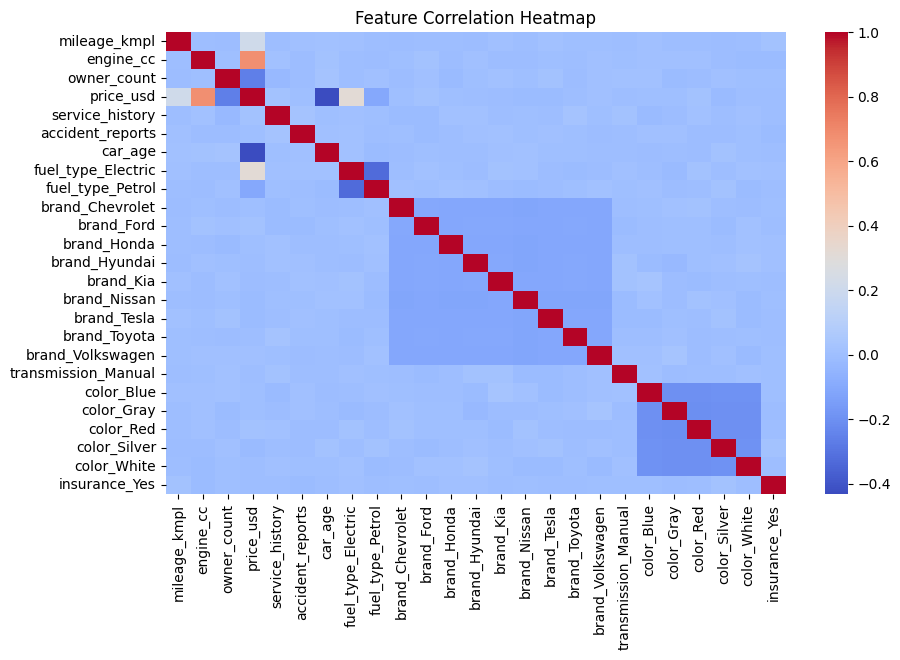


Top features correlated with price_usd:
price_usd             1.000000
engine_cc             0.678161
fuel_type_Electric    0.312584
mileage_kmpl          0.211971
color_Red             0.017251
brand_Ford            0.016184
service_history       0.015590
brand_Volkswagen      0.007371
brand_Honda           0.003299
color_Blue            0.002856
Name: price_usd, dtype: float64


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

#Calculate correlations to see which features relate most to our target, price_usd
corr = df_clean.corr()

#Visualizing these relationships with a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

#Print the top features
print("\nTop features correlated with price_usd:")
print(corr['price_usd'].sort_values(ascending=False).head(10))

<h4> 6. Check for outliers </h4>

In [17]:
#Using the IQR method to detect outliers, and values outside the 1.5 * IQR range
Q1 = df_clean['price_usd'].quantile(0.25)
Q3 = df_clean['price_usd'].quantile(0.75)

IQR = Q3 - Q1

outliers = df_clean[(df_clean['price_usd'] < Q1 - 1.5*IQR) | (df_clean['price_usd'] > Q3 + 1.5*IQR)]
print(f"\nOutliers in price_usd: {len(outliers)}")

#Save copy of dataset before removing outliers (just in case)
df_before_outliers = df_clean.copy()

#Removing outliers
df_clean = df_clean[(df_clean['price_usd'] >= Q1 - 1.5*IQR) & 
           (df_clean['price_usd'] <= Q3 + 1.5*IQR)]
print("\nOutliers removed")

print(f"Final dataset shape: {df_clean.shape}")


Outliers in price_usd: 58

Outliers removed
Final dataset shape: (9942, 25)


Save new cleaned data set

In [18]:
df_clean.to_csv('clean_used_car_data.csv', index=False)
print("\nCleaned data set saved to clean_used_car_data.csv")


Cleaned data set saved to clean_used_car_data.csv


<h2> Exploring the data </h2>
<p> Now that our data has been pre processed, we will visualize it using various graphs to gain insights into our cleaned dataset </p>
<h4> Histogram of Car Prices </h4>

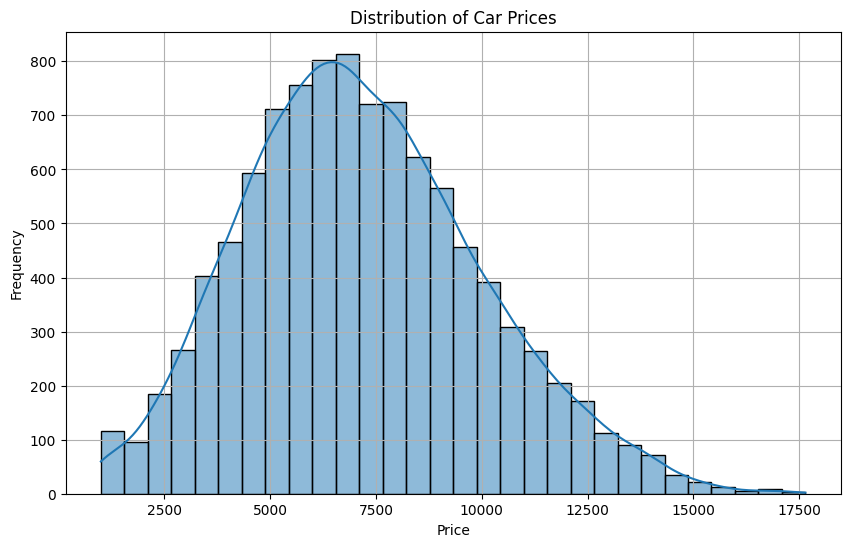

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(df_plot['price_usd'], bins=30, kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

 Slightly right skewed, showing most cars are listed between $5,000 to $8,000 and a few listed higher.

<h4> Mileage vs Price </h4>

In [20]:
#combining electric/petrol to one column
def detect_fuel_type(row):
    if row['fuel_type_Petrol']:
        return 'Petrol'
    elif row['fuel_type_Electric']:
        return 'Electric'
    else:
        return 'Other'  # in case both are false

df_plot['fuel_type'] = df_plot.apply(detect_fuel_type, axis=1)

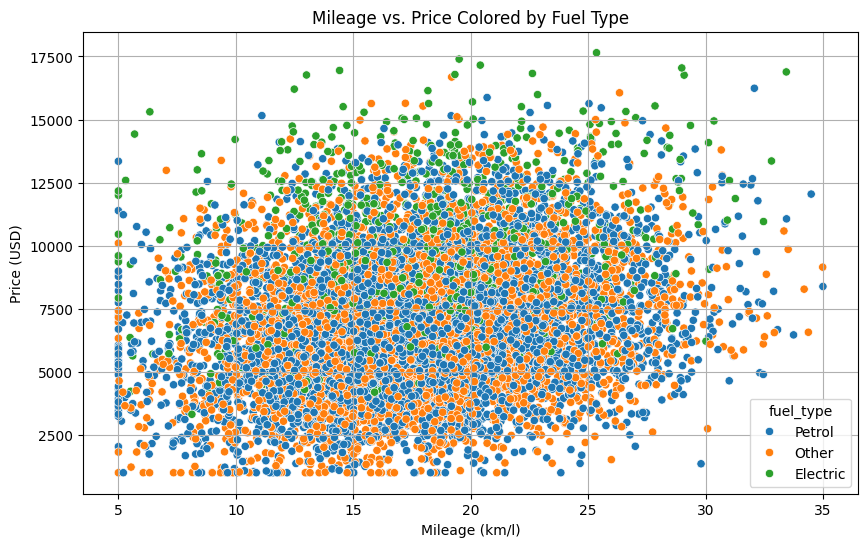

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='mileage_kmpl', y='price_usd', hue='fuel_type')
plt.title("Mileage vs. Price Colored by Fuel Type")
plt.xlabel("Mileage (km/l)")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

This scatter plot shows electric vehicles are slightly more expensive than petrol, but it does not show a strong relationship between mielage and price.

<h4> Engine Size vs Price </h4>

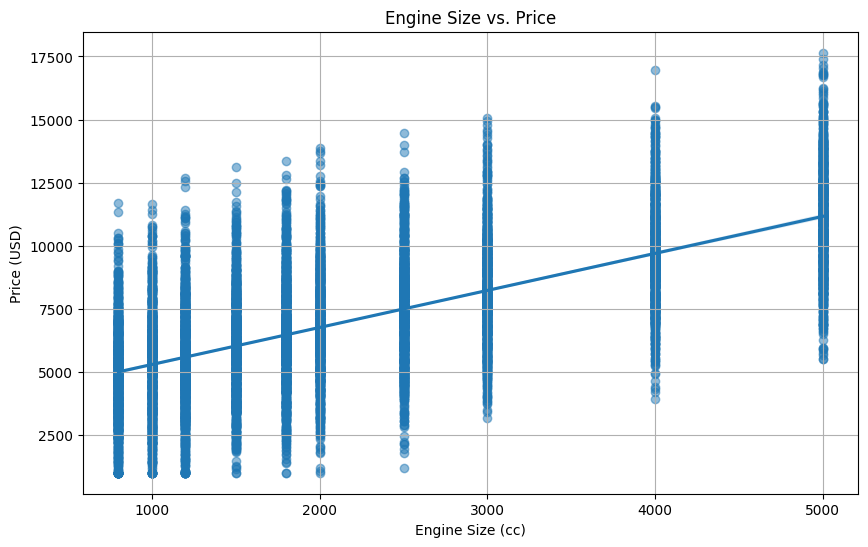

In [22]:
plt.figure(figsize=(10,6))
sns.regplot(data=df_plot, x='engine_cc', y='price_usd', scatter_kws={'alpha':0.5})
plt.title("Engine Size vs. Price")
plt.xlabel("Engine Size (cc)")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

This chart shows a positive linear relationship between engine size and the price. It does show a increase in price for larger engine sizes.

<h2> Data Modeling </h2>

<p> In this section, we will explore various models to train on our dataset. </p

<p> We start by defining functions that will help us calculate the MAE, RMSE, R-Square, and MAPE to evaluate the performance of our models </p>

In [23]:
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np

#Evaluating the model
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name}:")
    MAE = round(mean_absolute_error(y_true, y_pred), 2)
    RMSE = round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
    R2 = round(r2_score(y_true, y_pred), 4)
    MAPE = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)
    print("MAE:", MAE)
    print("RMSE:",RMSE)
    print("R² Score:", R2)
    print("MAPE:", MAPE)
    return MAE,RMSE,R2,MAPE

# Define the scoring metrics
scoring_metrics = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    'MAPE': make_scorer(lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100, greater_is_better=False)
}    

#Print results
def evaluate_with_cross_validation(model, X, y, model_name="Model"):
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoring_metrics)
    
    print(f"\n--- Cross-Validation Results: {model_name} ---")

    R2_avg = round(np.mean(cv_results['test_R2']), 4)
    print("R² Scores:", cv_results['test_R2'])
    print("Average R²:", R2_avg)
    
    MAE_avg = round(np.mean(-cv_results['test_MAE']), 2)
    print("MAE Scores:", -cv_results['test_MAE'])
    print("Average MAE:", MAE_avg)
    
    RMSE_avg = round(np.mean(-cv_results['test_RMSE']), 2)
    print("RMSE Scores:", -cv_results['test_RMSE'])
    print("Average RMSE:", RMSE_avg)
    
    MAPE_avg = round(np.mean(-cv_results['test_MAPE']), 2)
    print("MAPE Scores:", -cv_results['test_MAPE'])
    print("Average MAPE:", MAPE_avg, "%")
    return R2_avg, MAE_avg, RMSE_avg, MAPE_avg

<h4> Linear Regression </h4>

In [24]:
#Linear Regression
from sklearn.linear_model import LinearRegression

#defining x and y
features = ['mileage_kmpl', 'engine_cc', 'owner_count', 'accident_reports', 'car_age']
X_lr = df_clean[features]
y_lr = df_clean['price_usd']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

#Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

#Evaluating the model
lr_eval = evaluate_model(y_test, lr_preds, "Linear Regression")

#Perform 5-fold cross validation
lr_eval_with_cross_val = evaluate_with_cross_validation(lr, X_lr, y_lr, "Linear Regression")

Linear Regression:
MAE: 997.4
RMSE: 1334.22
R² Score: 0.7529
MAPE: 17.05

--- Cross-Validation Results: Linear Regression ---
R² Scores: [0.74327056 0.77105145 0.76484264 0.77547182 0.7572429 ]
Average R²: 0.7624
MAE Scores: [1023.27686986  993.21246347 1016.03657839 1007.9213114   985.48127668]
Average MAE: 1005.19
RMSE Scores: [1357.55978591 1318.40141579 1326.29482501 1327.44825791 1308.69930089]
Average RMSE: 1327.68
MAPE Scores: [17.70638209 17.33853482 18.19926644 17.39426714 16.20318843]
Average MAPE: 17.37 %


<h4> Random Forest Regression </h4>

In [25]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

#Preparing data for Random Forest
X_tree = df_plot.drop(columns=['price_usd', 'fuel_type'])
y_tree = df_plot['price_usd']

#Train/test split
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42)

#Define the model
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

#Train the model
rf.fit(X_train_tree, y_train_tree)

#Predictions based on test set
rf_preds = rf.predict(X_test_tree)

#Evaluate the single split
rf_eval = evaluate_model(y_test_tree, rf_preds, "Random Forest Regressor")

#Perform 5-fold cross validation
rf_eval_with_cross_val = evaluate_with_cross_validation(rf, X_tree, y_tree, "Random Forest Regressor")

Random Forest Regressor:
MAE: 851.7
RMSE: 1067.75
R² Score: 0.8567
MAPE: 15.34

--- Cross-Validation Results: Random Forest Regressor ---
R² Scores: [0.8479769  0.85521307 0.85418903 0.85447097 0.85703935]
Average R²: 0.8538
MAE Scores: [844.27771935 844.53060344 867.15453086 877.28977721 819.36769921]
Average MAE: 850.52
RMSE Scores: [1065.06644026 1067.81604304 1077.81181505 1098.04850805 1030.7001878 ]
Average RMSE: 1067.89
MAPE Scores: [15.26803898 15.11894552 15.84373166 15.51848644 14.02491579]
Average MAPE: 15.15 %


<h4> XGBoost Regressor </h4>

In [26]:
#XGBoost
from xgboost import XGBRegressor

#Define X and Y
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Preparing data
X_xgb = df_plot.drop(columns=['price_usd', 'fuel_type'])
y_xgb = df_plot['price_usd']

#Train/test split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42)

#Define the model
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

#Train the model
xgb.fit(X_train_xgb, y_train_xgb)

#Predictions based on test set
xgb_preds = xgb.predict(X_test_xgb)

#Evaluate model
xgb_eval = evaluate_model(y_test_xgb, xgb_preds, "XGBoost Regressor")

#Perform 5-fold cross validation
xgb_eval_with_cross_val = evaluate_with_cross_validation(xgb, X_xgb, y_xgb, "XGBoost Regressor")

XGBoost Regressor:
MAE: 824.01
RMSE: 1039.03
R² Score: 0.8643
MAPE: 14.76

--- Cross-Validation Results: XGBoost Regressor ---
R² Scores: [0.85592528 0.85981836 0.86085691 0.86894951 0.86420848]
Average R²: 0.862
MAE Scores: [818.34355617 824.79777931 847.68973123 833.11188448 806.69681476]
Average MAE: 826.13
RMSE Scores: [1036.84970361 1050.69660553 1052.8794872  1041.99594028 1004.52425511]
Average RMSE: 1037.39
MAPE Scores: [14.66676421 14.65923221 15.29197377 14.51623142 13.67301853]
Average MAPE: 14.56 %


<h4> Gradient Boosting Regressor </h4>

In [27]:
#Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

#Define X and Y
features = ['mileage_kmpl', 'engine_cc', 'owner_count', 'accident_reports', 'car_age']
X_gbr = df_clean[features]
y_gbr = df_clean['price_usd']

# Train/test split
X_train_gbr, X_test_gbr, y_train_gbr, y_test_gbr = train_test_split(X_gbr, y_gbr, test_size=0.2, random_state=42)

# Define model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train model
gbr.fit(X_train_gbr, y_train_gbr)

#Predictions based on test set
gbr_preds = gbr.predict(X_test_gbr)

# Evaluate on test data
gbr_eval = evaluate_model(y_test_gbr, gbr_preds, "Gradient Boosting Regressor")

# Cross-validation
gbr_eval_with_cross_val = evaluate_with_cross_validation(gbr, X_gbr, y_gbr, "Gradient Boosting Regressor")

Gradient Boosting Regressor:
MAE: 1011.26
RMSE: 1350.26
R² Score: 0.7469
MAPE: 17.32

--- Cross-Validation Results: Gradient Boosting Regressor ---
R² Scores: [0.73706276 0.76619986 0.7650776  0.77227936 0.74971522]
Average R²: 0.7581
MAE Scores: [1038.2172466  1012.07505942 1012.26992467 1018.73985287 1004.95413948]
Average MAE: 1017.25
RMSE Scores: [1373.87487995 1332.2971477  1325.63207684 1336.85213486 1328.83519039]
Average RMSE: 1339.5
MAPE Scores: [18.12407187 17.73345238 18.28844794 17.6292206  16.55224244]
Average MAPE: 17.67 %


<h2> Results and Interpretation </h2>
<p> After training and testing our models, we will compare their performance results </p>

<h4> Graphing the Models </h4>

<p> 
To compare the models, we generate 4 scatter plots to represent each model. A diagonal line shows perfect prediction, and the scattered points show the model's actual predictions.
</p>

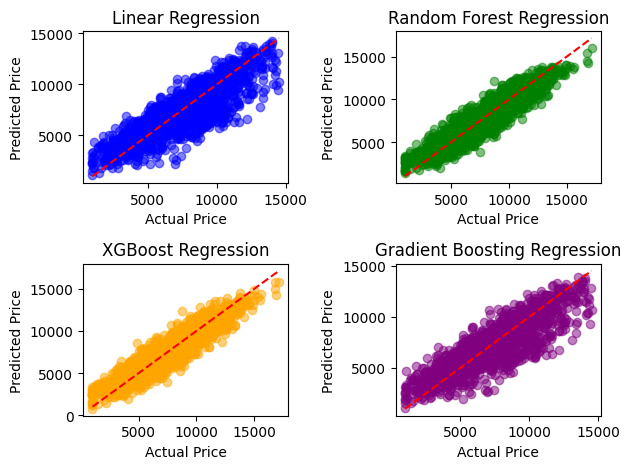

In [39]:
#Plotting the model predictions
def plot_model_predictions(z,test, preds, model_name, color):
    plt.subplot(2,2,z)
    plt.scatter(test, preds, alpha=0.5, color=color)
    plt.plot([test.min(), test.max()], [test.min(), test.max()], 'r--')
    plt.title(model_name)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")       

#Linear Regression
plot_model_predictions(1, y_test, lr_preds, "Linear Regression", "blue")

#Random Forest Regression
plot_model_predictions(2, y_test_tree, rf_preds, "Random Forest Regression", "green")

#XGBoost Regression
plot_model_predictions(3, y_test_xgb, xgb_preds, "XGBoost Regression", "orange")

#Gradient Boosting Regression
plot_model_predictions(4, y_test_gbr, gbr_preds, "Gradient Boosting Regression", "purple")

plt.tight_layout()
plt.show()

<p> We will also create a table to compare the performance of our models </p>

In [29]:
print("\n--- Model Evaluation Results ---")
results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting'],
    'R2': [lr_eval[2], rf_eval[2], xgb_eval[2], gbr_eval[2]],
    'MAE': [lr_eval[0], rf_eval[0], xgb_eval[0], gbr_eval[0]],  
    'RMSE': [lr_eval[1], rf_eval[1], xgb_eval[1], gbr_eval[1]],
    'MAPE': [lr_eval[3], rf_eval[3], xgb_eval[3], gbr_eval[3]]
}

eval_df = pd.DataFrame(results).sort_values(by='MAE')
print(eval_df.to_string(index=False))

print("\n--- Model Evaluation Results with 5-fold cross validation ---")
cv_results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting'],
    'R2': [lr_eval_with_cross_val[0], rf_eval_with_cross_val[0], xgb_eval_with_cross_val[0], gbr_eval_with_cross_val[0]],
    'MAE': [lr_eval_with_cross_val[1], rf_eval_with_cross_val[1], xgb_eval_with_cross_val[1], gbr_eval_with_cross_val[1]],
    'RMSE': [lr_eval_with_cross_val[2], rf_eval_with_cross_val[2], xgb_eval_with_cross_val[2], gbr_eval_with_cross_val[2]],
    'MAPE': [lr_eval_with_cross_val[3], rf_eval_with_cross_val[3], xgb_eval_with_cross_val[3], gbr_eval_with_cross_val[3]]
}
cv_eval_df = pd.DataFrame(cv_results).sort_values(by='MAE')
print(cv_eval_df.to_string(index=False))


--- Model Evaluation Results ---
            Model     R2     MAE    RMSE  MAPE
          XGBoost 0.8643  824.01 1039.03 14.76
    Random Forest 0.8567  851.70 1067.75 15.34
Linear Regression 0.7529  997.40 1334.22 17.05
Gradient Boosting 0.7469 1011.26 1350.26 17.32

--- Model Evaluation Results with 5-fold cross validation ---
            Model     R2     MAE    RMSE  MAPE
          XGBoost 0.8620  826.13 1037.39 14.56
    Random Forest 0.8538  850.52 1067.89 15.15
Linear Regression 0.7624 1005.19 1327.68 17.37
Gradient Boosting 0.7581 1017.25 1339.50 17.67
